In [1]:
import pandas as pd

In [2]:
df = pd.read_parquet("../../data/data_taxi_central_based.parquet")
df = df[(df['POLYLINE_LENGTH'] >= 30) & (df['POLYLINE_LENGTH'] < 276)]
df

,TRIP_ID,ORIGIN_CALL,TAXI_ID,TIMESTAMP,POLYLINE_LENGTH,LON,LAT
index,,,,,,,
398,1372637343620000571,31508.0,20000571,1372637343,32,-8.618868,41.155101
399,1372637343620000571,31508.0,20000571,1372637358,32,-8.617500,41.154912
400,1372637343620000571,31508.0,20000571,1372637373,32,-8.615079,41.154525
401,1372637343620000571,31508.0,20000571,1372637388,32,-8.613468,41.154228
402,1372637343620000571,31508.0,20000571,1372637403,32,-8.613261,41.154102
...,...,...,...,...,...,...,...
83407962,1403941536620000213,52688.0,20000213,1403942271,54,-8.620587,41.148045
83407963,1403941536620000213,52688.0,20000213,1403942286,54,-8.620848,41.149395
83407964,1403941536620000213,52688.0,20000213,1403942301,54,-8.620479,41.149710


In [3]:
import timesfm

 See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded PyTorch TimesFM, likely because python version is 3.11.13 | packaged by Anaconda, Inc. | (main, Jun  5 2025, 13:03:15) [MSC v.1929 64 bit (AMD64)].


In [4]:
df_lon = df.drop(columns=['ORIGIN_CALL', 'TAXI_ID', 'POLYLINE_LENGTH', 'LAT'])
df_lat = df.drop(columns=['ORIGIN_CALL', 'TAXI_ID', 'POLYLINE_LENGTH', 'LON'])

In [5]:
tfm_lat = timesfm.TimesFm(
      hparams=timesfm.TimesFmHparams(
          backend="gpu",
          per_core_batch_size=32,
          horizon_len=20,
          num_layers=50,
          use_positional_embedding=False,
          context_len=256,
      ),
      checkpoint=timesfm.TimesFmCheckpoint(
          huggingface_repo_id="google/timesfm-2.0-500m-pytorch"),
  )

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

In [6]:
tfm_lon = timesfm.TimesFm(
      hparams=timesfm.TimesFmHparams(
          backend="gpu",
          per_core_batch_size=32,
          horizon_len=20,
          num_layers=50,
          use_positional_embedding=False,
          context_len=256,
      ),
      checkpoint=timesfm.TimesFmCheckpoint(
          huggingface_repo_id="google/timesfm-2.0-500m-pytorch"),
  )

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

In [7]:
df_lat = df_lat.sort_values(by=['TRIP_ID', 'TIMESTAMP'])
df_lat_test = df_lat.groupby('TRIP_ID', group_keys=False).tail(20)
df_lat_train = df_lat.drop(df_lat_test.index)

In [8]:
df_lon = df_lon.sort_values(by=['TRIP_ID', 'TIMESTAMP'])
df_lon_test = df_lon.groupby('TRIP_ID', group_keys=False).tail(20)
df_lon_train = df_lon.drop(df_lat_test.index)

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler_lat = MinMaxScaler()
df_lat_train['LAT'] = scaler_lat.fit_transform(df_lat_train[['LAT']])

scaler_lon = MinMaxScaler()
df_lon_train['LON'] = scaler_lon.fit_transform(df_lon_train[['LON']])

In [10]:
df_lat_train['TIMESTAMP'] = pd.to_datetime(df_lat_train['TIMESTAMP'], unit='s')
df_lon_train['TIMESTAMP'] = pd.to_datetime(df_lon_train['TIMESTAMP'], unit='s')

In [11]:
df_lon_train = df_lon_train.rename(columns={'TIMESTAMP': 'ds', 'LON': 'y', 'TRIP_ID': 'unique_id'})
df_lat_train = df_lat_train.rename(columns={'TIMESTAMP': 'ds', 'LAT': 'y', 'TRIP_ID': 'unique_id'})

In [12]:
forecast_df_lon = tfm_lon.forecast_on_df(
    inputs=df_lon_train,
    freq="15s",
    value_name="y",
    num_jobs=-1,
)

Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.


In [13]:
forecast_df_lat = tfm_lon.forecast_on_df(
    inputs=df_lat_train,
    freq="15s",
    value_name="y",
    num_jobs=-1,
)

Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.


In [14]:
forecast_df_lon_keep = forecast_df_lon[['unique_id', 'ds', 'timesfm-q-0.9']]

In [15]:
forecast_df_lat_keep = forecast_df_lat[['unique_id', 'ds', 'timesfm-q-0.9']]

In [16]:
forecast_df_lat_keep['timesfm-q-0.9'] = scaler_lat.inverse_transform(forecast_df_lat_keep[['timesfm-q-0.9']])
forecast_df_lon_keep['timesfm-q-0.9'] = scaler_lon.inverse_transform(forecast_df_lon_keep[['timesfm-q-0.9']])

C:\Users\Nikola\AppData\Local\Temp\ipykernel_15320\3587103272.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_df_lat_keep['timesfm-q-0.9'] = scaler_lat.inverse_transform(forecast_df_lat_keep[['timesfm-q-0.9']])
C:\Users\Nikola\AppData\Local\Temp\ipykernel_15320\3587103272.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_df_lon_keep['timesfm-q-0.9'] = scaler_lon.inverse_transform(forecast_df_lon_keep[['timesfm-q-0.9']])


In [17]:
forecast_df_lat_keep = forecast_df_lat_keep.rename(columns={'timesfm-q-0.9': 'LAT_PREDICTED'})
forecast_df_lon_keep = forecast_df_lon_keep.rename(columns={'timesfm-q-0.9': 'LON_PREDICTED'})

In [18]:
forecast_df_lat_keep = forecast_df_lat_keep.sort_values(['unique_id', 'ds'])
forecast_df_lat_keep = forecast_df_lat_keep.groupby('unique_id').tail(1)

forecast_df_lon_keep = forecast_df_lon_keep.sort_values(['unique_id', 'ds'])
forecast_df_lon_keep = forecast_df_lon_keep.groupby('unique_id').tail(1)

In [19]:
df_lon_test = df_lon_test.rename(columns={'TIMESTAMP': 'ds', 'TRIP_ID': 'unique_id'})
df_lon_test = df_lon_test.sort_values(['unique_id', 'ds'])
df_lon_test = df_lon_test.groupby('unique_id').tail(1)

df_lat_test = df_lat_test.rename(columns={'TIMESTAMP': 'ds', 'TRIP_ID': 'unique_id'})
df_lat_test = df_lat_test.sort_values(['unique_id', 'ds'])
df_lat_test = df_lat_test.groupby('unique_id').tail(1)

In [20]:
result_lat = df_lat_test.merge(forecast_df_lat_keep, how='left', on=['unique_id'])
result_lon = df_lon_test.merge(forecast_df_lon_keep, how='left', on=['unique_id'])
result = result_lat.merge(result_lon, how='left', on=['unique_id'])

In [21]:
from evaluation_script import haversine_distance

In [22]:
result['DISTANCE_DELTA_SEPARATED'] = result.apply(lambda row: haversine_distance(
    row['LAT'], row['LON'], row['LAT_PREDICTED'], row['LON_PREDICTED']), axis=1)

In [23]:
result['DISTANCE_DELTA_SEPARATED'].mean()

np.float64(2.407945491788084)

In [24]:
result['DISTANCE_DELTA_SEPARATED'].median()

np.float64(1.9943297689716095)

In [25]:
result.to_csv("result.csv", index=False)

In [26]:
forecast_df_lat

,unique_id,ds,timesfm,timesfm-q-0.1,timesfm-q-0.2,timesfm-q-0.3,timesfm-q-0.4,timesfm-q-0.5,timesfm-q-0.6,timesfm-q-0.7,timesfm-q-0.8,timesfm-q-0.9
0,1372637254620000657,2013-07-01 00:13:19,0.764966,0.764105,0.764486,0.764682,0.764861,0.764966,0.765026,0.765093,0.765192,0.765493
1,1372637254620000657,2013-07-01 00:13:34,0.764978,0.763544,0.764130,0.764478,0.764775,0.764978,0.765126,0.765284,0.765484,0.765936
2,1372637254620000657,2013-07-01 00:13:49,0.764996,0.763027,0.763785,0.764265,0.764688,0.764996,0.765231,0.765464,0.765732,0.766264
3,1372637254620000657,2013-07-01 00:14:04,0.765031,0.762560,0.763477,0.764094,0.764614,0.765031,0.765340,0.765649,0.766008,0.766646
4,1372637254620000657,2013-07-01 00:14:19,0.765026,0.762225,0.763243,0.763942,0.764549,0.765026,0.765404,0.765777,0.766207,0.766943
...,...,...,...,...,...,...,...,...,...,...,...,...
5704575,1404172319620000571,2014-06-30 23:58:14,0.751835,0.738077,0.748638,0.748542,0.750641,0.751835,0.752266,0.751721,0.752925,0.761245
5704576,1404172319620000571,2014-06-30 23:58:29,0.750262,0.734895,0.744823,0.748350,0.748452,0.750262,0.750877,0.751801,0.751160,0.761531
5704577,1404172319620000571,2014-06-30 23:58:44,0.750135,0.735233,0.748300,0.749052,0.749607,0.750135,0.752264,0.753918,0.754748,0.761913
5704578,1404172319620000571,2014-06-30 23:58:59,0.751838,0.736453,0.749236,0.748897,0.751521,0.751838,0.753304,0.754191,0.753947,0.764449


In [27]:
columns = ['timesfm-q-0.1', 'timesfm-q-0.2', 'timesfm-q-0.3', 'timesfm-q-0.4', 'timesfm-q-0.5', 'timesfm-q-0.6', 'timesfm-q-0.7', 'timesfm-q-0.8', 'timesfm-q-0.9']

In [28]:
for column in columns:
    forecast_df_lat[column] = scaler_lat.inverse_transform(forecast_df_lat[[column]])
    forecast_df_lon[column] = scaler_lon.inverse_transform(forecast_df_lon[[column]])

In [29]:
forecast_df_lat = forecast_df_lat.sort_values(['unique_id', 'ds'])
forecast_df_lat = forecast_df_lat.groupby('unique_id').tail(1)

forecast_df_lon = forecast_df_lon.sort_values(['unique_id', 'ds'])
forecast_df_lon = forecast_df_lon.groupby('unique_id').tail(1)

In [30]:
result_lat = df_lat_test.merge(forecast_df_lat, how='left', on=['unique_id'])
result_lon = df_lon_test.merge(forecast_df_lon, how='left', on=['unique_id'])
result = result_lat.merge(result_lon, how='left', on=['unique_id'])

In [31]:
result

,unique_id,ds_x_x,LAT,ds_y_x,timesfm_x,timesfm-q-0.1_x,timesfm-q-0.2_x,timesfm-q-0.3_x,timesfm-q-0.4_x,timesfm-q-0.5_x,...,timesfm_y,timesfm-q-0.1_y,timesfm-q-0.2_y,timesfm-q-0.3_y,timesfm-q-0.4_y,timesfm-q-0.5_y,timesfm-q-0.6_y,timesfm-q-0.7_y,timesfm-q-0.8_y,timesfm-q-0.9_y
0,1372637254620000657,1372637884,41.181813,2013-07-01 00:18:04,0.764022,41.167191,41.170837,41.173481,41.176064,41.178295,...,0.835264,-8.632835,-8.626487,-8.622577,-8.619802,-8.617633,-8.615479,-8.613070,-8.609822,-8.604194
1,1372637343620000571,1372637808,41.162265,2013-07-01 00:16:48,0.755190,41.154400,41.155029,41.155418,41.155739,41.156078,...,0.836597,-8.620522,-8.616243,-8.613790,-8.611950,-8.610364,-8.609030,-8.607776,-8.606016,-8.602690
2,1372637397620000190,1372638222,41.177214,2013-07-01 00:23:42,0.758368,41.121090,41.138725,41.154072,41.160618,41.164074,...,0.839004,-8.634700,-8.630521,-8.610821,-8.601146,-8.597239,-8.588931,-8.573452,-8.570667,-8.548972
3,1372638303620000112,1372640028,41.162436,2013-07-01 00:53:48,0.758109,41.156845,41.159103,41.160679,41.162052,41.163422,...,0.840511,-8.601382,-8.596800,-8.593702,-8.591201,-8.589021,-8.587005,-8.585005,-8.582798,-8.579835
4,1372638451620000621,1372638961,41.193315,2013-07-01 00:36:01,0.766063,41.167301,41.172550,41.176403,41.179943,41.183430,...,0.840796,-8.603762,-8.598248,-8.594364,-8.590796,-8.587470,-8.584249,-8.581251,-8.578007,-8.572858
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285224,1404170795620000242,1404171290,41.176404,2014-06-30 23:34:50,0.757760,41.159538,41.160694,41.161392,41.161942,41.162548,...,0.832608,-8.679445,-8.655724,-8.636982,-8.634605,-8.632120,-8.626783,-8.613413,-8.616045,-8.583224
285225,1404171078620000455,1404171858,41.150700,2014-06-30 23:44:18,0.756791,41.151901,41.155056,41.157085,41.158665,41.160103,...,0.837895,-8.612741,-8.609334,-8.606896,-8.604921,-8.603286,-8.601951,-8.600636,-8.599367,-8.597740
285226,1404171293620000565,1404171803,41.141025,2014-06-30 23:43:23,0.753716,41.146694,41.149342,41.150661,41.151646,41.152370,...,0.836109,-8.614435,-8.613725,-8.613367,-8.613178,-8.613026,-8.612857,-8.612604,-8.612190,-8.611331
285227,1404172208620000196,1404172763,41.176890,2014-06-30 23:59:23,0.765981,41.180462,41.181423,41.182079,41.182659,41.183228,...,0.838435,-8.608393,-8.604870,-8.602877,-8.601471,-8.600345,-8.599362,-8.598266,-8.597019,-8.594354


In [32]:
df_lat_test

,unique_id,ds,LAT
index,,,
723,1372637254620000657,1372637884,41.181813
429,1372637343620000571,1372637808,41.162265
4104,1372637397620000190,1372638222,41.177214
2623,1372638303620000112,1372640028,41.162436
1975,1372638451620000621,1372638961,41.193315
...,...,...,...
83392765,1404170795620000242,1404171290,41.176404
83393328,1404171078620000455,1404171858,41.150700
83391403,1404171293620000565,1404171803,41.141025


In [34]:
for col in columns:
    result[f'DISTANCE_DELTA_SEPARATED_{col}'] = result.apply(lambda row: haversine_distance(
    row['LAT'], row['LON'], row[f'{col}_x'], row[f'{col}_y']), axis=1)

In [36]:
for col in columns:
    print(f"Column: {col}   Mean: {result[f'DISTANCE_DELTA_SEPARATED_{col}'].mean()}    Median: {result[f'DISTANCE_DELTA_SEPARATED_{col}'].median()}")

Column: timesfm-q-0.1   Mean: 3.674037899367754    Median: 2.429797979009097
Column: timesfm-q-0.2   Mean: 2.798390522825094    Median: 1.9777297739881674
Column: timesfm-q-0.3   Mean: 2.1525470024171285    Median: 1.578090659804726
Column: timesfm-q-0.4   Mean: 1.8973048617488317    Median: 1.436348504755426
Column: timesfm-q-0.5   Mean: 1.7694252044474226    Median: 1.3754826000108027
Column: timesfm-q-0.6   Mean: 1.7074225932643123    Median: 1.357599341311954
Column: timesfm-q-0.7   Mean: 1.7706400729594731    Median: 1.453190606065266
Column: timesfm-q-0.8   Mean: 1.893003371036355    Median: 1.5668752773131625
Column: timesfm-q-0.9   Mean: 2.407945491788084    Median: 1.9943297689716095


In [37]:
import matplotlib.pyplot as plt

In [40]:
stats = []
for col in columns:
    mean_val = result[f'DISTANCE_DELTA_SEPARATED_{col}'].mean()
    median_val = result[f'DISTANCE_DELTA_SEPARATED_{col}'].median()
    label = col.replace("timesfm-", "")
    stats.append({"quantile": label, "mean": mean_val, "median": median_val})

df_stats = pd.DataFrame(stats)

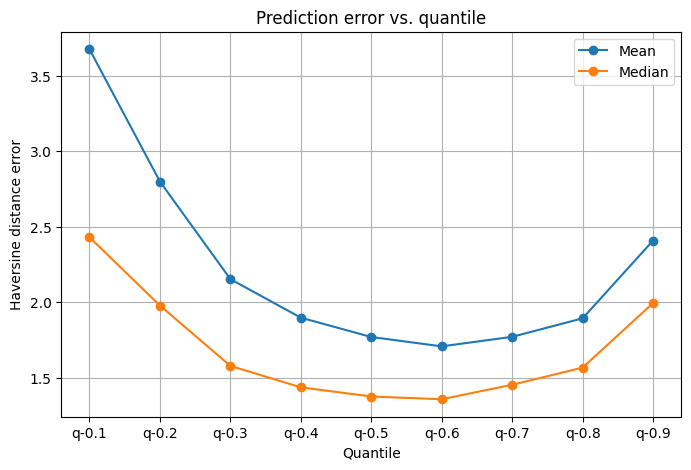

In [41]:
plt.figure(figsize=(8,5))
plt.plot(df_stats["quantile"], df_stats["mean"], marker="o", label="Mean")
plt.plot(df_stats["quantile"], df_stats["median"], marker="o", label="Median")
plt.xlabel("Quantile")
plt.ylabel("Haversine distance error")
plt.title("Prediction error vs. quantile")
plt.legend()
plt.grid(True)
plt.show()